# Run the imports before running anything else!

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime as dt
import datetime
from itertools import compress
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline

## Data processing, exploratory
To see the final data preparation function and the data analysis implementation, scroll down to "Data preparation: one function".
The code until that point is given to illustrate the process that let me arrive at that final function.

In [7]:
#First we need to take a look at the data
listings_df = pd.read_csv(r'data\boston\listings.csv',sep=',',quotechar='"')
listings_df.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,12147973,https://www.airbnb.com/rooms/12147973,20160906204935,2016-09-07,Sunny Bungalow in the City,"Cozy, sunny, family home. Master bedroom high...",The house has an open and cozy feel at the sam...,"Cozy, sunny, family home. Master bedroom high...",none,"Roslindale is quiet, convenient and friendly. ...",...,NaN,f,NaN,NaN,f,moderate,f,f,1,NaN
1,3075044,https://www.airbnb.com/rooms/3075044,20160906204935,2016-09-07,Charming room in pet friendly apt,Charming and quiet room in a second floor 1910...,Small but cozy and quite room with a full size...,Charming and quiet room in a second floor 1910...,none,"The room is in Roslindale, a diverse and prima...",...,9.0,f,NaN,NaN,t,moderate,f,f,1,1.30
2,6976,https://www.airbnb.com/rooms/6976,20160906204935,2016-09-07,Mexican Folk Art Haven in Boston,"Come stay with a friendly, middle-aged guy in ...","Come stay with a friendly, middle-aged guy in ...","Come stay with a friendly, middle-aged guy in ...",none,The LOCATION: Roslindale is a safe and diverse...,...,10.0,f,NaN,NaN,f,moderate,t,f,1,0.47
3,1436513,https://www.airbnb.com/rooms/1436513,20160906204935,2016-09-07,Spacious Sunny Bedroom Suite in Historic Home,Come experience the comforts of home away from...,Most places you find in Boston are small howev...,Come experience the comforts of home away from...,none,Roslindale is a lovely little neighborhood loc...,...,10.0,f,NaN,NaN,f,moderate,f,f,1,1.00
4,7651065,https://www.airbnb.com/rooms/7651065,20160906204935,2016-09-07,Come Home to Boston,"My comfy, clean and relaxing home is one block...","Clean, attractive, private room, one block fro...","My comfy, clean and relaxing home is one block...",none,"I love the proximity to downtown, the neighbor...",...,10.0,f,NaN,NaN,f,flexible,f,f,1,2.25


In [12]:
#And at the column list
listings_df.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'access', 'interaction', 'house_rules',
       'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url',
       'host_id', 'host_url', 'host_name', 'host_since', 'host_location',
       'host_about', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url',
       'host_picture_url', 'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'street',
       'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms',

In [13]:
#How is the price represented?
listings_df[['price','weekly_price','monthly_price']].head()

,price,weekly_price,monthly_price
0,$250.00,NaN,NaN
1,$65.00,$400.00,NaN
2,$65.00,$395.00,"$1,350.00"
3,$75.00,NaN,NaN
4,$79.00,NaN,NaN


In [14]:
#Do we need to retain information about the license?
listings_df['requires_license'].unique()

array(['f'], dtype=object)

In [30]:
#Do we have longitude and latitude? If we don't, then we won't be easily able to answer questions about distance to city center
listings_df[listings_df['is_location_exact'] == 'f'][['longitude','latitude']].head()

,longitude,latitude
15,-122.372893,47.635650
20,-122.364959,47.627940
51,-122.373779,47.638298
65,-122.392594,47.669327
69,-122.378666,47.670662


### Questions for analysis:

* Do central locations in Boston and Seattle provide better anemities (beds, wi-fi, kitchen)? Are there any differences between cities? We'll use basic descriptive statistics to explore.
* Does distance from downtown have a bigger impact on lodging price for Seattle or for Boston for AirBnB (after controlling for other variables)? We'll create another feature (distance to downtown based on the city center longitude and latitude) and build a basic supervised learning model. The goal here isn't to predict price but to look for a simple, monotone relationship between the distance to city center and listing price.
* Do people end up happier with staying closer to downtown after controlling for other variables? We'll reuse the previous model, only now we'll use average review score as a target.

## Data Preparation and Cleaning

First, let's decide which columns we should drop to avoid cluttering our DataFrame
* listing_url, thumbnail_url, medium_url, picture_url, xl_picture_url, host_thumbnail_url, host_picture_url - all the urls can be safely dropped
* scrape_id
* last_scraped - all rows have one date
* name, summary, space, description, experiences_offered ('none'), neighborhood_overview, notes, transit, host_name, host_about - text analysis was out-of-scope for this research as it is a separate project in itself. If these comments and descriptions we dropped are unexpectedly connected with how central a house is, then we might be in trouble but we should be fine. What we are doing here is treating how central a home is as a proxy for ease of transit, neighborhood quality, and other hard-to-analyze text fields. We don't expect the location to be a magical power acting on price on itself, but rather expect it to stand in for ease of access to city entertainment and business hubs and for the concentration of anemities in the neighborhood.
* host_id, host_url, host_location
* street - this is too detailed. For future analysis, we could make a dummy variable for especially expensive streets, but we won't do this now
* neighbourhood - we already have a cleaned-up neighbourhood and neighbourhood group courtesy of AirBnB
* city, state, market, country_code, country, smart_location - same for all rows
* weekly price, monthly price - don't need those for now. Could use them to remove some noise from the 'price' feature.
* security_deposit isn't something that influences price but rather another target variable that we could analyze.
* license - always NaN for Seattle and Boston. It and 'requires_license' aren't necessary
* review_scores_rating, review_scores_accuracy, review_scores_cleanliness, review_scores_checkin, review_scores_communication,  review_scores_location, review_scores_value - we are interested only in apartment properties and not in review scores
* calendar_last_scraped - meaningless as a predictor

In [2]:
#Columns to drop
drop_cols = [
    'listing_url', 'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url', 'host_thumbnail_url', 'host_picture_url', 
    'scrape_id', 'last_scraped', 
    'name', 'summary', 'space', 'description', 'experiences_offered', 'neighborhood_overview', 'notes', 'transit', 
    'host_name', 'host_about', 'host_location', 'host_id', 'host_url',
    'street', 'neighbourhood', 'city', 'state', 'market', 'country_code', 'country', 'smart_location', 
    'weekly_price', 'monthly_price', 'security_deposit', 'requires_license', 'license','calendar_last_scraped',
    'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 
    'review_scores_communication', 'review_scores_location', 'review_scores_value',
    'access','interaction','house_rules'
]

In [3]:
def preprocess_listings(df, drop_cols, drop_nonexact=False):
    """
    Function cleans a listings DataFrame by dropping a list of columns
    and then dropping the listings with nonexact location if needed
    """
    #Need to ignore errors because we'll be applying this to two cities
    #and this lets us to apply the Seattle column list to Boston
    #without worrying about a couple columns not existing in the
    #Boston dataset
    
    pre_df = df.drop(drop_cols, axis=1,errors='ignore')
    
    #Under our circumstances, it's not necessary to drop non-exact locations
    #as AirBnB guarantees that locations are accurate with 150-meter accuracy
    #anyway: http://insideairbnb.com/about.html#disclaimers
    if drop_nonexact:
        pre_df = pre_df[pre_df['is_location_exact'] == 't']
    
    #Drop is_location_exact as it's a purelytechnical variable
    #and we have no more use for it
    pre_df = pre_df.drop(['is_location_exact'], axis=1)
    
    return pre_df

In [18]:
#Dropping the columns
seattle_cleaned = preprocess_listings(listings_df, drop_cols)

In [19]:
#Let's take a look at the results
seattle_cleaned.head()

,id,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,...,number_of_reviews,first_review,last_review,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,12147973,2015-04-15,NaN,NaN,NaN,f,Roslindale,1,1,"['email', 'phone', 'facebook', 'reviews']",...,0,NaN,NaN,NaN,f,moderate,f,f,1,NaN
1,3075044,2012-06-07,within an hour,100%,100%,f,Roslindale,1,1,"['email', 'phone', 'facebook', 'linkedin', 'am...",...,36,2014-06-01,2016-08-13,NaN,t,moderate,f,f,1,1.30
2,6976,2009-05-11,within a few hours,100%,88%,t,Roslindale,1,1,"['email', 'phone', 'reviews', 'jumio']",...,41,2009-07-19,2016-08-05,NaN,f,moderate,t,f,1,0.47
3,1436513,2013-04-21,within a few hours,100%,50%,f,NaN,1,1,"['email', 'phone', 'reviews']",...,1,2016-08-28,2016-08-28,NaN,f,moderate,f,f,1,1.00
4,7651065,2014-05-11,within an hour,100%,100%,t,Roslindale,1,1,"['email', 'phone', 'reviews', 'kba']",...,29,2015-08-18,2016-09-01,NaN,f,flexible,f,f,1,2.25


In [20]:
#Some columns have a list of options encoded in them
#Let's take a look at anemities
test_str = seattle_cleaned['amenities'][0]
print(test_str[1:-1])

TV,"Wireless Internet",Kitchen,"Free Parking on Premises","Pets live on this property",Dog(s),Heating,"Family/Kid Friendly",Washer,Dryer,"Smoke Detector","Fire Extinguisher",Essentials,Shampoo,"Laptop Friendly Workspace"


We'll need to transform every such column into several boolean columns, one for each of the options possible. We'll also need to clean the new column names.

In [4]:
def split_itemlist(in_str, prefix='', sep=',', search=['"',"'",'/',' '], replace=['','','','_']):
    """
    Function splits a string into a list of items and reformats them to be usable as column names
    
    Args:
        in_str(str): string to be split into a list of formatted column names
    Output:
        out_list(list): list of formatted column names
    """
    
    #Remove the braces if they exist
    if in_str[0] in ['[','{']:
        in_str = in_str[1:-1]
    
    out_list = in_str.split(sep)
    for ind, item in enumerate(out_list):
        temp_str = out_list[ind]
        temp_str = temp_str.lower()
        temp_str = temp_str.strip()
        for s, r in zip(search, replace):
            temp_str = temp_str.replace(s,r)
        out_list[ind] = temp_str
    
    return out_list

In [5]:
def split_combination(df,col_list):
    """
    Function splits a columns which has a string encoding a list of options in it
    each option gets its own dummy column encoded with 1 and 0. Original column is dropped.
    Resets the DataFrame index to make sure that everything fits.
    
    Note on implementation: it's important to avoid editing a DataFrame inside a loop,
    so that's why we use a numpy array and then convert and concatenate.
    
    Args:
        in_df(DataFrame): DataFrame with columns to be split
    Output:
        df(DataFrame): DataFrame with split columns
    """
    
    df.reset_index()
    
    new_cols = {}
    
    #Let's preallocate space for new columns
    #This will break if we need to add more than 100 columns
    #but it's fine for our problem
    
    new_arr = np.zeros((len(df), 100))
    
    rcount = 0
    #print(df.head())
    col_ind = 0
    for index,row in df.iterrows():
        #print(row['amenities'])
        for col in col_list:
            #print(col)
            split_list = split_itemlist(row[col],prefix=(col + '_'))
            for sp_col in split_list:
                if not(sp_col in new_cols):
                    #print(sp_col)
                    #print(new_cols)
                    new_cols[sp_col] = col_ind
                    col_ind += 1
                try:
                    new_arr[rcount][new_cols[sp_col]] = 1
                except:
                    print(new_cols)
                    raise
        rcount += 1
    
    new_arr = new_arr[:,:len(new_cols)]
        
    #df[new_cols.keys()] = new_arr
    
    app_df = pd.DataFrame(new_arr, columns=new_cols.keys(), index=df.index)
    df = pd.concat([df, app_df], axis=1)
    #Drop the original columns
    df = df.drop(labels=col_list, axis=1)
    
    return df

In [8]:
#Let's split the columns that have lists in them
expand_cols = ['amenities','host_verifications']

#Record the current date
seattle_date = listings_df['last_scraped'].iloc[0]
#Drop all unnecessary columns
seattle_cleaned = preprocess_listings(listings_df, drop_cols, True)
print('Remaining columns before split:')
print(seattle_cleaned.columns)
print('Total number of rows in DataFrame before split is {:d}'.format(len(seattle_cleaned)))
print('Total number of columns in DataFrame before split is {:d}'.format(len(seattle_cleaned.columns)))
start = dt.now()
seattle_cleaned = split_combination(seattle_cleaned,expand_cols)
print('Execution took {} '.format(dt.now() - start))
print('Total number of rows in DataFrame after split is {:d}'.format(len(seattle_cleaned)))
print('Total number of columns in DataFrame after splitis {:d}'.format(len(seattle_cleaned.columns)))

Remaining columns before split:
Index(['id', 'host_since', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'host_neighbourhood',
       'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'zipcode',
       'latitude', 'longitude', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', 'square_feet',
       'price', 'cleaning_fee', 'guests_included', 'extra_people',
       'minimum_nights', 'maximum_nights', 'calendar_updated',
       'has_availability', 'availability_30', 'availability_60',
       'availability_90', 'availability_365', 'number_of_reviews',
       'first_review', 'last_review', 'jurisdiction_names', 'instant_bookable',
       'cancellation_policy', 'require_guest_profile_picture',
       'require_guest_phone_verification', 'ca

In [24]:
#We need to record the target and quantitative variables 
#since other variables are qualitative and need encoding

t_col = ['price']
quant_cols = ['host_since','host_response_rate','host_acceptance_rate',
              'host_listings_count','host_total_listings_count','latitude','longitude',
              'accommodates','bathrooms','bedrooms','beds','square_feet','price',
              'cleaning_fee','guests_included','extra_people','minimum_nights','maximum_nights',
              'calculated_host_listings_count','reviews_per_month','first_review','last_review',
             'availability_30','availability_60','availability_90','availability_365',
             'number_of_reviews','dist_to_center']

In [27]:
#Let's see how rates are encoded
seattle_cleaned['host_response_rate'].head()

0     NaN
1    100%
2    100%
4    100%
5    100%
Name: host_response_rate, dtype: object

In [28]:
#Let's check that we got the date-encoding format correctly
dt.strptime(seattle_cleaned['host_since'].iloc[0],'%Y-%m-%d')

datetime.datetime(2015, 4, 15, 0, 0)

In [9]:
def get_date_diff(df, col, cur_date_str, dt_format='%Y-%m-%d'):
    """
    Turns a column of string-encoded dates to a column
    of log-differences between the encoded date and the current date
    
    Args:
    df (DataFrame): DataFrame with the column to be reencoded
    col (str) - name of the column
    cur_date_str (str): the date at which the Dataset was formed
        last scrape date or equivalent should be passed in dt_format
        format
    dt_format (str) - date format to use for encoding
    
    """
    
    cur_date = dt.strptime(cur_date_str,dt_format)
    df[col] = df[col].apply(lambda x: dt.strptime(x,dt_format) if isinstance(x, str) else x)
    
    #We expect the effect of date differences to be larger when they are small, 
    #so let's reingeneer the differnce into logarithmic scale
    df[col] = df[col].apply(lambda x: np.log((cur_date - x).days) if isinstance(x, datetime.date) else x)
    
    return df

In [10]:
#We need to convert some variables

seattle_cleaned = get_date_diff(seattle_cleaned, 'host_since', seattle_date)
seattle_cleaned = get_date_diff(seattle_cleaned, 'first_review', seattle_date)
seattle_cleaned = get_date_diff(seattle_cleaned, 'last_review', seattle_date)

seattle_cleaned['host_since'].head()

0    6.236370
1    7.347944
2    7.892078
4    6.745236
5    5.123964
Name: host_since, dtype: float64

In [11]:
#Convert some moree numbers encoded as strings to numbers

#Convert rates
seattle_cleaned['host_response_rate'] = seattle_cleaned['host_response_rate'].apply(lambda x: float(x[:-1]) if isinstance(x,str) else x)
seattle_cleaned['host_acceptance_rate'] = seattle_cleaned['host_acceptance_rate'].apply(lambda x: float(x[:-1]) if isinstance(x,str) else x)

#Amounts in dollars. Have a digit ',' separator in them
seattle_cleaned['price'] = seattle_cleaned['price'].apply(lambda x: float(x[1:].replace(',','')) if isinstance(x,str) else x)
seattle_cleaned['cleaning_fee'] = seattle_cleaned['cleaning_fee'].apply(lambda x: float(x[1:].replace(',','')) if isinstance(x,str) else x)
seattle_cleaned['extra_people'] = seattle_cleaned['extra_people'].apply(lambda x: float(x[1:].replace(',','')) if isinstance(x,str) else x)


In [33]:
def get_center_dist(df, center_lat, center_long):
    """
    The function takes a AirBnB DataFrame and the latitude and longitude
    of the city center, and then it outputs a dataframe with an added column
    that has a distance from the center
    
    Args:
    df (DataFrame): DataFrame that needs distance to center to be added
    center_lat (float): latitude of the city center
    center_long (float): longitude of the city center
    
    Out:
    df (DataFrame): DataFrame with the longitude column added
    """
    def dist(row, center_lat=center_lat, center_long=center_long):
        res = (row['latitude'] - center_lat)**2 + (row['longitude'] - center_long)**2
        return res
    
    dist_col = df.apply(dist, axis = 1)
    df['dist_to_center'] = dist_col
    return df

In [34]:
#We'll define the residential center of the city 
#as the mean in latitude and the mean in longitude
cent_lat = seattle_cleaned.mean()['latitude']
cent_long = seattle_cleaned.mean()['longitude']

s_dist = get_center_dist(seattle_cleaned, cent_lat, cent_long)

In [36]:
#We don't need longitude and latitude anymore
s_dist.drop(['latitude','longitude'],axis=1,inplace=True)

In [41]:
#Analyse fraction of missing values by column
miss_fracts = s_dist.isnull().sum() / len(s_dist)
miss_fracts.unique()

array([0.00000000e+00, 1.35714286e-01, 5.19480519e-03, 1.00000000e+00,
       1.62337662e-03, 9.74025974e-04, 3.57142857e-03, 3.24675325e-03,
       9.82467532e-01, 3.00649351e-01, 2.03571429e-01])

In [43]:
#We need to drop everything with more than a certain amount of missing values
#We'll drop columns that miss more than 30%. The percentage is based on based on
#miss_fracts.unique()
miss_fracts = miss_fracts[miss_fracts >= 0.3]

In [44]:
miss_fracts

neighbourhood_group_cleansed    1.000000
square_feet                     0.982468
cleaning_fee                    0.300649
has_availability                1.000000
jurisdiction_names              1.000000
dtype: float64

In [45]:
s_dist.drop(labels=list(miss_fracts.index),axis=1,inplace=True)

In [46]:
#Check that our main target has no missing values
s_dist['price'].isnull().values.any()

False

## Data preparation: one function (after imports, start running from here)

What is outlined above is exploratory data preparation. We need to combine the parts of the cells above that process the data (omitting the ones that output all the descriptive results we used to build the process). This will allow us to run all the data processing in one step.

In [24]:
def data_load_and_preprocess(listings_csv_path, 
                             drop_cols, list_cols, date_cols, rate_cols, dollar_cols,
                            miss_cutoff, drop_nonexact=False):
    """
    Does all the data preparation in one step.
    
    Args:
    listings_csv_path (str): path to a city listings csv file
    drop_cols (list): columns to be dropped
    list_cols (list): columns with encoded lists that need to be broken up
    date_cols (list): columns with dates that need to be turned into log difference
               with the current date
    rate_cols (list): columns with rates that need to be converted into floats
    dollar_cols (list): columns with dollar values that need to be converted into floats
    miss_cutoff (float): rate of missing values above which columns should be dropped
    drop_nonexact (bool): whether we should drop rows with nonexact locations
    
    Out:
    listings_cleaned (DataFrame): a preprocessed DataFrame
    listings_long_lat (DataFrame): longitude and latitude columns from the
                                   original DataFrame
    """
    
    #Helper functions
    def drop_listing_cols(df, drop_cols, drop_nonexact=False):
        """
        Function cleans a listings DataFrame by dropping a list of columns
        and then dropping th elistings with nonexact location if needed
        """
        #Need to ignore errors because we'll be applying this to two cities
        #and this lets us to apply the Seattle column list to Boston
        #without worrying about a couple columns not existing in the
        #Boston dataset

        pre_df = df.drop(drop_cols, axis=1,errors='ignore')

        #Under our circumstances, it's not necessary to drop non-exact locations
        #as AirBnB guarantees that locations are accurate with 150-meter accuracy
        #anyway: http://insideairbnb.com/about.html#disclaimers
        if drop_nonexact:
            pre_df = pre_df[pre_df['is_location_exact'] == 't']

        #Drop is_location_exact as it's a purelytechnical variable
        #and we have no more use for it
        pre_df = pre_df.drop(['is_location_exact'], axis=1)

        return pre_df
    
    def split_itemlist(in_str, prefix='', sep=',', search=['"',"'",'/',' '], replace=['','','','_']):
        """
        Function splits a string into a list of items and reformats them to be usable as column names

        Args:
            in_str(str): string to be split into a list of formatted column names
        Output:
            out_list(list): list of formatted column names
        """

        #Remove the braces if they exist
        if in_str[0] in ['[','{']:
            in_str = in_str[1:-1]

        out_list = in_str.split(sep)
        for ind, item in enumerate(out_list):
            temp_str = out_list[ind]
            temp_str = temp_str.lower()
            temp_str = temp_str.strip()
            for s, r in zip(search, replace):
                temp_str = temp_str.replace(s,r)
            out_list[ind] = temp_str

        return out_list
    
    def split_combination(df,col_list):
        """
        Function splits a columns which has a string encoding a list of options in it
        each option gets its own dummy column encoded with 1 and 0. Original column is dropped.
        Resets the DataFrame index to make sure that everything fits.

        Note on implementation: it's important to avoid editing a DataFrame inside a loop,
        so that's why we use a numpy array and then convert and concatenate.

        Args:
            in_df(DataFrame): DataFrame with columns to be split
        Output:
            df(DataFrame): DataFrame with split columns
        """

        df.reset_index()

        new_cols = {}

        #Let's preallocate space for new columns
        #This will break if we need to add more than 100 columns
        #but it's fine for our problem

        new_arr = np.zeros((len(df), 100))

        rcount = 0
        #print(df.head())
        col_ind = 0
        for index,row in df.iterrows():
            #print(row['amenities'])
            for col in col_list:
                #print(col)
                split_list = split_itemlist(row[col],prefix=(col + '_'))
                for sp_col in split_list:
                    if not(sp_col in new_cols):
                        #print(sp_col)
                        #print(new_cols)
                        new_cols[sp_col] = col_ind
                        col_ind += 1
                    try:
                        new_arr[rcount][new_cols[sp_col]] = 1
                    except:
                        print(new_cols)
                        raise
            rcount += 1

        new_arr = new_arr[:,:len(new_cols)]

        #df[new_cols.keys()] = new_arr

        app_df = pd.DataFrame(new_arr, columns=new_cols.keys(), index=df.index)
        df = pd.concat([df, app_df], axis=1)
        #Drop the original columns
        df = df.drop(labels=col_list, axis=1)

        return df
    
    def get_date_diff(df, col, cur_date_str, dt_format='%Y-%m-%d'):
        """
        Turns a column of string-encoded dates to a column
        of log-differences between the encoded date and the current date

        Args:
        df (DataFrame): DataFrame with the column to be reencoded
        col (str) - name of the column
        cur_date_str (str): the date at which the Dataset was formed
            last scrape date or equivalent should be passed in dt_format
            format
        dt_format (str) - date format to use for encoding
        
        Out:
        df (DataFrame): DataFrame with date converted to long diff
                        with current date
        """

        cur_date = dt.strptime(cur_date_str,dt_format)
        df[col] = df[col].apply(lambda x: dt.strptime(x,dt_format) if isinstance(x, str) else x)

        #We expect the effect of date differences to be larger when they are small, 
        #so let's reingeneer the differnce into logarithmic scale
        df[col] = df[col].apply(lambda x: np.log((cur_date - x).days) if isinstance(x, datetime.date) else x)

        return df
    
    def get_center_dist(df, center_lat, center_long):
        """
        The function takes a AirBnB DataFrame and the latitude and longitude
        of the city center, and then it outputs a dataframe with an added column
        that has a distance from the center
        """
        def dist(row, center_lat=center_lat, center_long=center_long):
            res = (row['latitude'] - center_lat)**2 + (row['longitude'] - center_long)**2
            return res

        dist_col = df.apply(dist, axis = 1)
        df['dist_to_center'] = dist_col
        return df
    
    #Main script
    listings_df = pd.read_csv(listings_csv_path,sep=',',quotechar='"')
    
    #Get current date
    listings_date = listings_df['last_scraped'].iloc[0]
    
    #Drop the unnecessary columns
    listings_cleaned = drop_listing_cols(listings_df, drop_cols)
    #Expand columns that have lists encoded in them
    listings_cleaned = split_combination(listings_cleaned,list_cols)
    
    for col in date_cols:
        listings_cleaned = get_date_diff(listings_cleaned, col, listings_date)
    
    #The 'isinstance' is there to make sure that if the column is already reencoded,
    #nothing happens
    for col in rate_cols:
        listings_cleaned[col] = listings_cleaned[col].apply(lambda x: float(x[:-1]) if isinstance(x,str) else x)
    
    for col in dollar_cols:
        listings_cleaned[col] = listings_cleaned[col].apply(lambda x: float(x[1:].replace(',','')) if isinstance(x,str) else x)
    
    #Add a column with the diestance to the city center
    cent_lat = listings_cleaned.mean()['latitude']
    cent_long = listings_cleaned.mean()['longitude']

    listings_cleaned = get_center_dist(listings_cleaned, cent_lat, cent_long)
    listings_long_lat = listings_cleaned[['longitude','latitude']]
    listings_cleaned.drop(['latitude','longitude'],axis=1,inplace=True)
    
    #Remove columns with too many missing values
    miss_fracts = listings_cleaned.isnull().sum() / len(listings_cleaned)
    miss_fracts = miss_fracts[miss_fracts >= 0.3]
    listings_cleaned.drop(labels=list(miss_fracts.index),axis=1,inplace=True)
    
    return listings_cleaned, listings_long_lat

In [20]:
#Default settings for preprocessing
#About the review scores: for this analysis, we'll be keeping only
#the integral score as the second target variable we'll be analyzing
drop_cols = [
    'listing_url', 'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url', 'host_thumbnail_url', 'host_picture_url', 
    'scrape_id', 'last_scraped', 
    'name', 'summary', 'space', 'description', 'experiences_offered', 'neighborhood_overview', 'notes', 'transit', 
    'host_name', 'host_about', 'host_location', 'host_id', 'host_url',
    'street', 'neighbourhood', 'city', 'state', 'market', 'country_code', 'country', 'smart_location', 
    'weekly_price', 'monthly_price', 'security_deposit', 'requires_license', 'license','calendar_last_scraped',
    'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 
    'review_scores_communication', 'review_scores_location', 'review_scores_value',
    'access','interaction','house_rules'
]
list_cols = ['amenities','host_verifications']
date_cols = ['host_since','first_review','last_review']
rate_cols = ['host_response_rate','host_acceptance_rate']
dollar_cols = ['price','cleaning_fee','extra_people']
miss_cutoff = 0.3

In [25]:
#Let's load Seattle data
seattle_csv_path = r'data\seattle\listings.csv'
seattle_clean, seattle_long_lat = data_load_and_preprocess(seattle_csv_path, 
                                         drop_cols, list_cols, date_cols, rate_cols, dollar_cols,
                                         miss_cutoff)

seattle_clean.head()


,id,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_neighbourhood,host_listings_count,host_total_listings_count,host_has_profile_pic,...,pool,smoking_allowed,other_pet(s),sent_id,doorman,photographer,none,weibo,washer__dryer,dist_to_center
0,241032,7.382124,within a few hours,96.0,100.0,f,Queen Anne,3.0,3.0,t,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001492
1,953595,6.953684,within an hour,98.0,100.0,t,Queen Anne,6.0,6.0,t,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001164
2,3308979,6.347389,within a few hours,67.0,100.0,f,Queen Anne,2.0,2.0,t,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001324
3,7421966,6.670766,NaN,NaN,NaN,f,Queen Anne,1.0,1.0,t,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001399
4,278830,7.311218,within an hour,100.0,NaN,f,Queen Anne,2.0,2.0,t,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001565


In [26]:
#And now Boston
boston_csv_path = r'data\boston\listings.csv'
boston_clean, boston_long_lat = data_load_and_preprocess(boston_csv_path, 
                                         drop_cols, list_cols, date_cols, rate_cols, dollar_cols,
                                         miss_cutoff)
boston_clean.head()

,id,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_neighbourhood,host_listings_count,host_total_listings_count,host_has_profile_pic,...,google,wheelchair_accessible,elevator_in_building,sent_id,pool,doorman,weibo,paid_parking_off_premises,free_parking_on_street,dist_to_center
0,12147973,6.236370,NaN,NaN,NaN,f,Roslindale,1,1,t,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.005624
1,3075044,7.347944,within an hour,100.0,100.0,f,Roslindale,1,1,t,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.005349
2,6976,7.892078,within a few hours,100.0,88.0,t,Roslindale,1,1,t,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.004861
3,1436513,7.118826,within a few hours,100.0,50.0,f,NaN,1,1,t,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.004783
4,7651065,6.745236,within an hour,100.0,100.0,t,Roslindale,1,1,t,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.005729


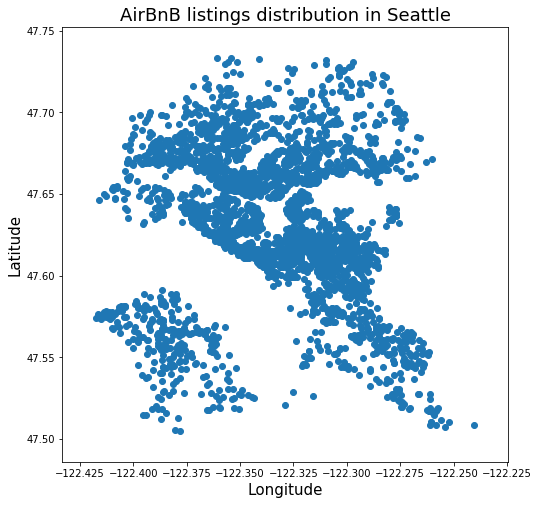

In [54]:
#Here we must check that the distribution in Seattle doesn't have 
#several equally important centers
plt.figure(figsize=(8,8))
plt.scatter(x=seattle_long_lat['longitude'],y=seattle_long_lat['latitude'])
plt.title("AirBnB listings distribution in Seattle", fontsize=18)
plt.ylabel("Latitude", fontsize=15)
plt.xlabel("Longitude", fontsize=15)
#plt.show()
plt.savefig('seattle_housing_distribution.png')

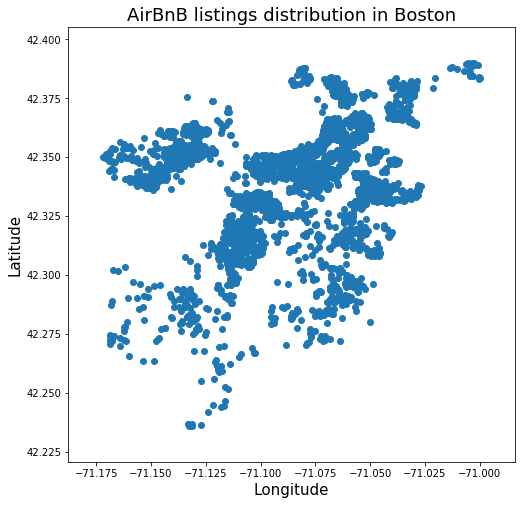

In [55]:
#Here we must check that the distribution in Boston doesn't have 
#several equally important centers
plt.figure(figsize=(8,8))
plt.scatter(boston_long_lat['longitude'],boston_long_lat['latitude'])
plt.title("AirBnB listings distribution in Boston", fontsize=18)
plt.ylabel("Latitude", fontsize=15)
plt.xlabel("Longitude", fontsize=15)
#plt.show()
plt.savefig('boston_housing_distribution.png')

## Data analysis
It's time to find answers to our questions. If we cleaned the data right, this should be easy.

### Question 1: How is distance to center related to amenities? 
We have fartoo many amenities to look at everythink, so let's make the question more specific.
Specifically, how is distance to center related to the number of beds, presence of wi-fi, and presence of a kitchen?

### Toolkit for Question 1
For this question it will be enough to look at correlations between dist_to_center, beds, wireless_internet, and kitchen.

In [32]:
#Set the columns
cols = ['dist_to_center', 'beds', 'wireless_internet', 'kitchen']

In [62]:
#Calculate and display results for Seattle
print(seattle_clean[cols].corr().loc['dist_to_center',:])

dist_to_center       1.000000
beds                 0.025743
wireless_internet    0.002275
kitchen             -0.098075
Name: dist_to_center, dtype: float64


In [63]:
#And now for Boston
print(boston_clean[cols].corr().loc['dist_to_center',:])

dist_to_center       1.000000
beds                 0.025735
wireless_internet    0.021236
kitchen             -0.060018
Name: dist_to_center, dtype: float64


### Discussing Question 1 results
The correlations aren't very strong, but consistent across Seattle and Boston when it comes to the number of beds and the presence of a kitchen. The further from center, the more beds we found, and the less likely we were to find a kitchen. We were more likely to find wireless_internet, but the result was very different for the two cities, so we should put less stock in it.
It must be noted, that correlation is bounded between -1 and 1, so these relationships aren't very strong.
Listings on the edges of cities have more space available, so they have more beds. The lesser likelihood of finding a kitchen far from the city center is a surprise though. Is it because further from the center people are more likely to rent out rooms instead of entire flats or houses? This warrants further research.

### Representing results

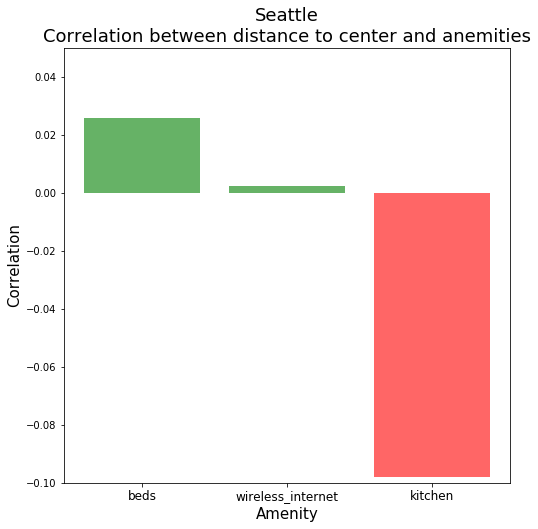

In [50]:
#Seattle results
seattle_cors = seattle_clean[cols].corr().loc['dist_to_center',:]
seattle_cors = seattle_cors.drop(['dist_to_center'], axis=0)

plt.figure(figsize=(8,8))
plt.bar(x=list(seattle_cors.index), height=seattle_cors, color=['g','g','r'], alpha=0.6)
plt.xlabel('Amenity', fontsize=15)
plt.xticks(fontsize=12)
plt.ylabel('Correlation', fontsize=15)
plt.ylim([-0.1,0.05])
plt.title('Seattle\nCorrelation between distance to center and anemities',fontsize=18)
#plt.show()
plt.savefig('seattle_dist_and_anemities.png')

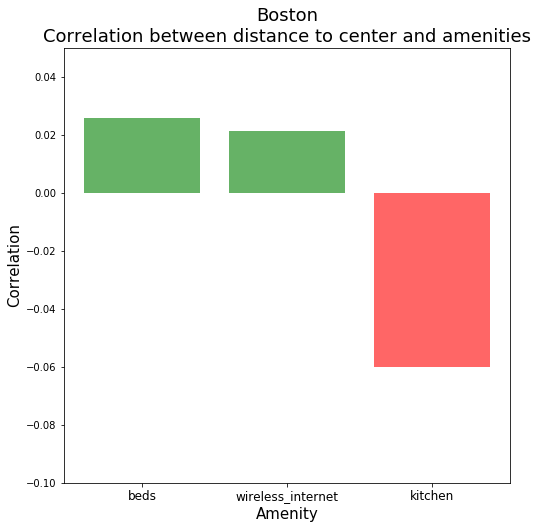

In [51]:
#Boston results
boston_cors = boston_clean[cols].corr().loc['dist_to_center',:]
boston_cors = boston_cors.drop(['dist_to_center'], axis=0)

plt.figure(figsize=(8,8))
plt.bar(x=list(boston_cors.index), height=boston_cors, color=['g','g','r'], alpha=0.6)
plt.xlabel('Amenity', fontsize=15)
plt.xticks(fontsize=12)
plt.ylabel('Correlation', fontsize=15)
plt.ylim([-0.1,0.05])
plt.title('Boston\nCorrelation between distance to center and amenities', fontsize=18)
#plt.show()
plt.savefig('boston_dist_and_anemities.png')

### Additional data processing for Questions 2 and 3
Questions 2 and 3 will have us runnning a Lasso regression on the data, and it requires that there be no missing values and that the qualitative variables be one-hot-encoded. Let's do the additional processing for both questions in one place.

In [56]:
#First we should drop the id column. We now know we won't be linking data from the other csv files
seattle_clean = seattle_clean.drop('id', axis=1)
boston_clean = boston_clean.drop('id', axis=1)

In [57]:
t_col = ['price','review_scores_rating']
quant_cols = ['host_since','host_response_rate','host_acceptance_rate',
              'host_listings_count','host_total_listings_count','latitude','longitude',
              'accommodates','bathrooms','bedrooms','beds','square_feet','price',
              'cleaning_fee','guests_included','extra_people','minimum_nights','maximum_nights',
              'calculated_host_listings_count','reviews_per_month','first_review','last_review',
             'availability_30','availability_60','availability_90','availability_365',
             'number_of_reviews','dist_to_center']

In [58]:
def encode_and_impute(df, cols_not_encode):
    """
    The function one-hot encodes qualitative variables
    and imputes the missing values
    
    Args:
    df (DataFrame): DataFrame that needs encoding and imputing

    Out:
    df (DataFrame): DataFrame after encoding and imputing
    """
    
    cols_to_encode = set(df.columns) - set(cols_not_encode)
    df = pd.get_dummies(df,columns=cols_to_encode, drop_first=True)
    #We should impute all the quantitive columns
    df = df.fillna(df.mean())
    
    return df

In [59]:
cols_not_encode = ['price','review_scores_rating',
                  'host_since','host_response_rate','host_acceptance_rate',
                  'host_listings_count','host_total_listings_count','latitude','longitude',
                  'accommodates','bathrooms','bedrooms','beds','square_feet','price',
                  'cleaning_fee','guests_included','extra_people','minimum_nights','maximum_nights',
                  'calculated_host_listings_count','reviews_per_month','first_review','last_review',
                  'availability_30','availability_60','availability_90','availability_365',
                  'number_of_reviews','dist_to_center']

In [60]:
seattle_clean = encode_and_impute(seattle_clean, cols_not_encode)
boston_clean = encode_and_impute(boston_clean, cols_not_encode)

### Finishing touches
We should drop the id column and build a function that take a listings dataframe and separates it into the target variable and explanatory features column-wise and into the training and test sets row-wise.

In [61]:
def finish_listings(df, target_col, drop_cols=None, test_size=0.2, random_state=42):
    """
    This function takes the dataset and returns the target column series
    and a DataFrame that has the explanatory features
    
    Args:
    df (DataFrame): DataFrame to be split
    target_col (str): the target column name
    drop_cols (list): a list of columns that need to be dropped before
                      forming X
    
    Out:
    X_train, X_test, y_train, y_test: split data
    """
    
    df1 = df.copy()
    
    if drop_cols:
        df1.drop(drop_cols, axis=1, inplace=True)
    
    y = df1[target_col]
    X = df1.drop(target_col, axis=1)
    
    #Now we need to standartize X
    X_cols = X.columns
    scaler = StandardScaler()
    scaler.fit(X)
    X = scaler.transform(X)
    X = pd.DataFrame(X, columns=X_cols)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    return X_train, X_test, y_train, y_test

## Question 2. After controlling for other variables, how does distance to center influence price per day in Boston and Seattle?

We could try answering this question this way:

In [62]:
seattle_clean[['dist_to_center','price']].corr()

,dist_to_center,price
dist_to_center,1.000000,-0.130401
price,-0.130401,1.000000


This does tell us that distance to center is negatively related to price as we expected, but that is sloppy data science. There are a bunch of other factors that influence price that are correlated to distance to the city center, so we need to control for those. That's why we need to use a regression model with regularization to make sure that we ar elooking only at the influence of this particular variable on price.
We'll be using a Lasso regressionas it is very good at removing unnecessary variables.
Let's take a look.

In [100]:
#Seattle
#It's important to drop the review scores here as they are another target, and we
#are mostly interested in apartment properties as features
X_train, X_test, y_train, y_test = finish_listings(seattle_clean, 'price', 'review_scores_rating')

#Make the regression and fit it
#Note: different alphas were tested. The particular number isn't really important
#alpha needs to be increased to unreasonable levels for distance to center to become
#insignificant as a factor
lr = Lasso(alpha=0.6)
lr.fit(X_train,y_train)

#Let's see how we did
print('The model explained the following fraction of variance on the test set')
print(lr.score(X_test,y_test))

dist_index=list(X_test.columns).index('dist_to_center')
print('The distance to center coefficient is:')
print(lr.coef_[dist_index])
print('The lowest coefficient is: ',lr.coef_.min())
print('The largest coefficient is: ',lr.coef_.max())

#This takes up way too much space
#print('All the non-zero coefficients are:')
#coef = np.array(lr.coef_)
#coef_ind = (coef != 0)
#print(list(zip(compress(list(X_test.columns),coef_ind),compress(list(coef),coef_ind))))

The model explained the following fraction of variance on the test set
0.5486588552589107
The distance to center coefficient is:
-7.235286345405494
The lowest coefficient is:  -14.507339913777091
The largest coefficient is:  22.33147498541072


C:\Users\amatamune\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\amatamune\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.


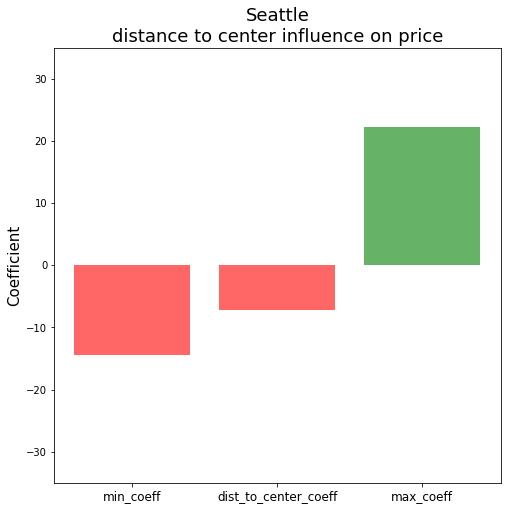

In [101]:
#Representing results

height = [lr.coef_.min(), lr.coef_[dist_index], lr.coef_.max()]
x = ['min_coeff', 'dist_to_center_coeff', 'max_coeff']

plt.figure(figsize=(8,8))
plt.bar(x=x, height=height, color=['r','r','g'], alpha=0.6)
plt.xticks(fontsize=12)
plt.ylabel('Coefficient', fontsize=15)
plt.ylim([-35,35])
plt.title('Seattle\ndistance to center influence on price',fontsize=18)
#plt.show()
plt.savefig('seattle_dist_and_price.png')

In [102]:
#Boston
#It's important to drop the review scores here as they are another target, and we
#are mostly interested in apartment properties as features
X_train, X_test, y_train, y_test = finish_listings(boston_clean, 'price', 'review_scores_rating')

#Make the regression and fit it
#Note: different alphas were tested. The particular number isn't really important
#alpha needs to be increased to unreasonable levels for distance to center to become
#insignificant as a factor
lr = Lasso(alpha=0.6)
lr.fit(X_train,y_train)

#Let's see how we did
print('The model explained the following fraction of variance on the test set')
print(lr.score(X_test,y_test))

dist_index=list(X_test.columns).index('dist_to_center')
print('The distance to center coefficient is:')
print(lr.coef_[dist_index])
print('The lowest coefficient is: ',lr.coef_.min())
print('The largest coefficient is: ',lr.coef_.max())

#This takes up way too much space
#print('All the non-zero coefficients are:')
#coef = np.array(lr.coef_)
#coef_ind = (coef != 0)
#print(list(zip(compress(list(X_test.columns),coef_ind),compress(list(coef),coef_ind))))

The model explained the following fraction of variance on the test set
0.2474790545684812
The distance to center coefficient is:
-11.918981574190187
The lowest coefficient is:  -25.871032266094353
The largest coefficient is:  29.97129959198702


C:\Users\amatamune\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\amatamune\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.


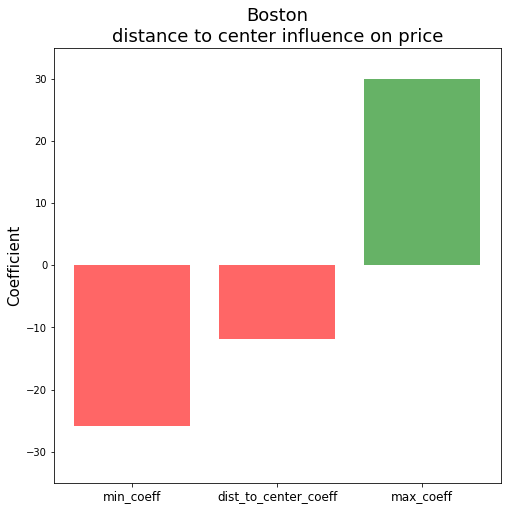

In [103]:
#Representing results

height = [lr.coef_.min(), lr.coef_[dist_index], lr.coef_.max()]
x = ['min_coeff', 'dist_to_center_coeff', 'max_coeff']

plt.figure(figsize=(8,8))
plt.bar(x=x, height=height, color=['r','r','g'], alpha=0.6)
plt.xticks(fontsize=12)
plt.ylabel('Coefficient', fontsize=15)
plt.ylim([-35,35])
plt.title('Boston\ndistance to center influence on price',fontsize=18)
#plt.show()
plt.savefig('Boston_dist_and_price.png')

### Question 2 results discussion
We see that the distance to center strongly impacts the price negatively for both cities even after controlling for neighborhoods and all the anemities. City center apartments come with easy access to tourist attractions and city facilities, so this is expected. The effect is considerably stronger for Boston though, which is interesting. Boston looks to be more dense in the center, but this warrants further investigation.

## Question 3. How does distance to center influence custumer satisfaction in Boston and Seattle?

In [104]:
#Seattle
#It's important to drop the review scores here as they are another target, and we
#are mostly interested in apartment properties as features
X_train, X_test, y_train, y_test = finish_listings(seattle_clean, 'review_scores_rating', 'price')

#Make the regression and fit it
#Note: different alphas were tested. The particular number isn't really important
#alpha needs to be increased to unreasonable levels for distance to center to become
#insignificant as a factor
lr = Lasso(alpha=0.3)
lr.fit(X_train,y_train)

#Let's see how we did
print('The model explained the following fraction of variance on the test set')
print(lr.score(X_test,y_test))

dist_index=list(X_test.columns).index('dist_to_center')
print('The distance to center coefficient is:')
print(lr.coef_[dist_index])
print('The lowest coefficient is: ',lr.coef_.min())
print('The largest coefficient is: ',lr.coef_.max())

#This takes up way too much space
#print('All the non-zero coefficients are:')
#coef = np.array(lr.coef_)
#coef_ind = (coef != 0)
#print(list(zip(compress(list(X_test.columns),coef_ind),compress(list(coef),coef_ind))))

The model explained the following fraction of variance on the test set
0.11391588369220564
The distance to center coefficient is:
0.0
The lowest coefficient is:  -0.6276314894944125
The largest coefficient is:  0.9010551629186377


C:\Users\amatamune\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\amatamune\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.


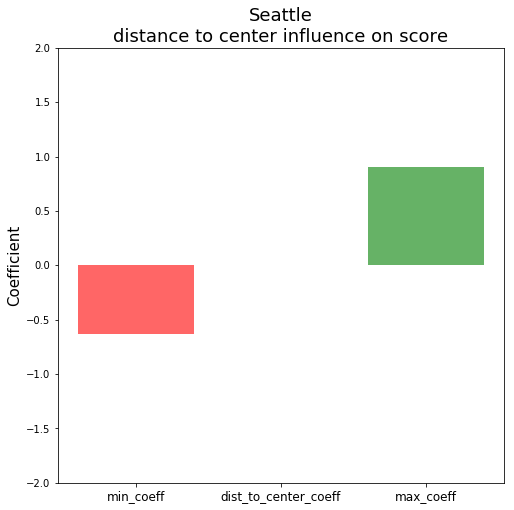

In [105]:
#Representing results

height = [lr.coef_.min(), lr.coef_[dist_index], lr.coef_.max()]
x = ['min_coeff', 'dist_to_center_coeff', 'max_coeff']

plt.figure(figsize=(8,8))
plt.bar(x=x, height=height, color=['r','r','g'], alpha=0.6)
plt.xticks(fontsize=12)
plt.ylabel('Coefficient', fontsize=15)
plt.ylim([-2,2])
plt.title('Seattle\ndistance to center influence on score',fontsize=18)
#plt.show()
plt.savefig('Seattle_dist_and_score.png')

In [106]:
#Boston
#It's important to drop the review scores here as they are another target, and we
#are mostly interested in apartment properties as features
X_train, X_test, y_train, y_test = finish_listings(boston_clean, 'review_scores_rating', 'price')

#Make the regression and fit it
#Note: different alphas were tested. The particular number isn't really important
#alpha needs to be increased to unreasonable levels for distance to center to become
#insignificant as a factor
lr = Lasso(alpha=0.3)
lr.fit(X_train,y_train)

#Let's see how we did
print('The model explained the following fraction of variance on the test set')
print(lr.score(X_test,y_test))

dist_index=list(X_test.columns).index('dist_to_center')
print('The distance to center coefficient is:')
print(lr.coef_[dist_index])
print('The lowest coefficient is: ',lr.coef_.min())
print('The largest coefficient is: ',lr.coef_.max())

#This takes up way too much space
#print('All the non-zero coefficients are:')
#coef = np.array(lr.coef_)
#coef_ind = (coef != 0)
#print(list(zip(compress(list(X_test.columns),coef_ind),compress(list(coef),coef_ind))))

The model explained the following fraction of variance on the test set
0.08942423151735601
The distance to center coefficient is:
0.0
The lowest coefficient is:  -0.7019307705468061
The largest coefficient is:  1.1326585951366537


C:\Users\amatamune\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\amatamune\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.


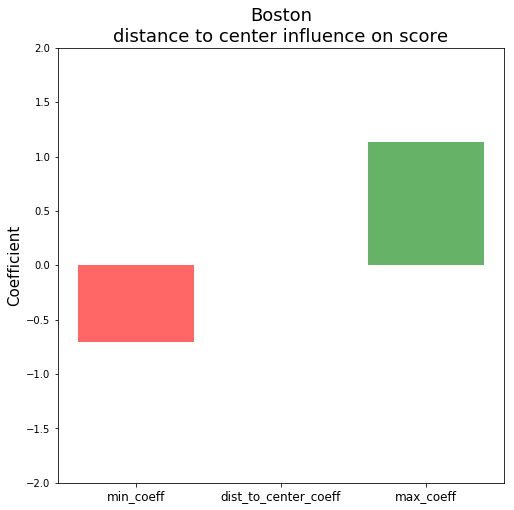

In [107]:
#Representing results

height = [lr.coef_.min(), lr.coef_[dist_index], lr.coef_.max()]
x = ['min_coeff', 'dist_to_center_coeff', 'max_coeff']

plt.figure(figsize=(8,8))
plt.bar(x=x, height=height, color=['r','r','g'], alpha=0.6)
plt.xticks(fontsize=12)
plt.ylabel('Coefficient', fontsize=15)
plt.ylim([-2,2])
plt.title('Boston\ndistance to center influence on score',fontsize=18)
#plt.show()
plt.savefig('Boston_dist_and_score.png')

### Question 3 results discussion
We might say that the distance to center doesn't have any effect on the average score, but the truth is that our model simply doesn't predict custumer satisfaction well. 9% of variance explained is very little. There could be two reasons: either we need a more complex model, or the data used doesn't have enough information to predict how satisfied a custumer will be.
I'm leaning toward the former but further research is needed. It's out of scope of this project however.